<a href="https://colab.research.google.com/github/eireford/ConwayLifeTensorFlow/blob/master/LTF_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from IPython.display import clear_output

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
    '\n\nThis error most likely means that this notebook is not '
    'configured to use a GPU.  Change this in Notebook Settings via the '
    'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')
print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


In [0]:
FEATURES_SHAPE = [1024,1024,1]
LABELS_SHAPE = [1024,1024,1]
SET_SIZE = 200

def random_uniform_grid(shape=FEATURES_SHAPE):
  return tf.round(tf.random.uniform(shape=shape,dtype=tf.float32))

In [0]:
def convolve_for_density_map(X):
  life_density_kernal = tf.constant([[[[1]],[[1]],[[1]]],
                                   [[[1]],[[10]],[[1]]],
                                   [[[1]],[[1]],[[1]]]],dtype=tf.float32)
  X_reshaped = tf.reshape(X,[1,X.shape[0],X.shape[1],1])
  density_map = tf.nn.conv2d(X_reshaped,life_density_kernal,[1,1,1,1],"SAME")
  density_map = tf.reshape(density_map,X.shape)
  return tf.round(density_map)

def will_be_alive(density_map):
  is_three = tf.equal(density_map,3.0)
  is_twelve = tf.equal(density_map,12.0)
  is_thirteen = tf.equal(density_map,13.0)
  any_true = is_three | is_twelve | is_thirteen
  return tf.cast(any_true,dtype=tf.float32)

def step_heuristic(X):
  density_map = convolve_for_density_map(X)
  return will_be_alive(density_map)

In [0]:
def get_data_examples(size = SET_SIZE):
  for i in range(size):
    X = random_uniform_grid()
    Y = step_heuristic(X)
    yield X,Y

def get_dataset():
  return tf.data.Dataset.from_generator(get_data_examples,(tf.float32,tf.float32),(tf.TensorShape(FEATURES_SHAPE),tf.TensorShape(LABELS_SHAPE)))
  
X_COMMON = get_dataset()

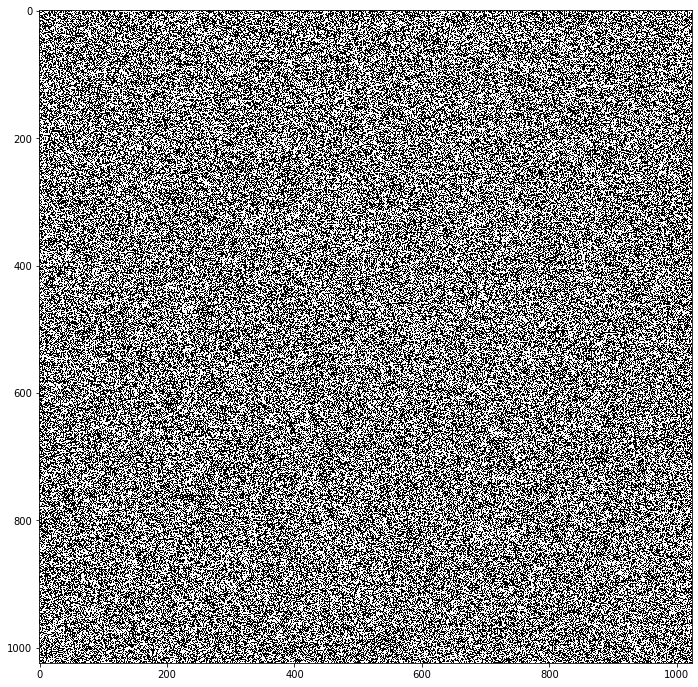

In [5]:
for element in X_COMMON: 
  e = element
  break
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(tf.squeeze(e[0]),cmap='Greys',origin='upper',interpolation='nearest')

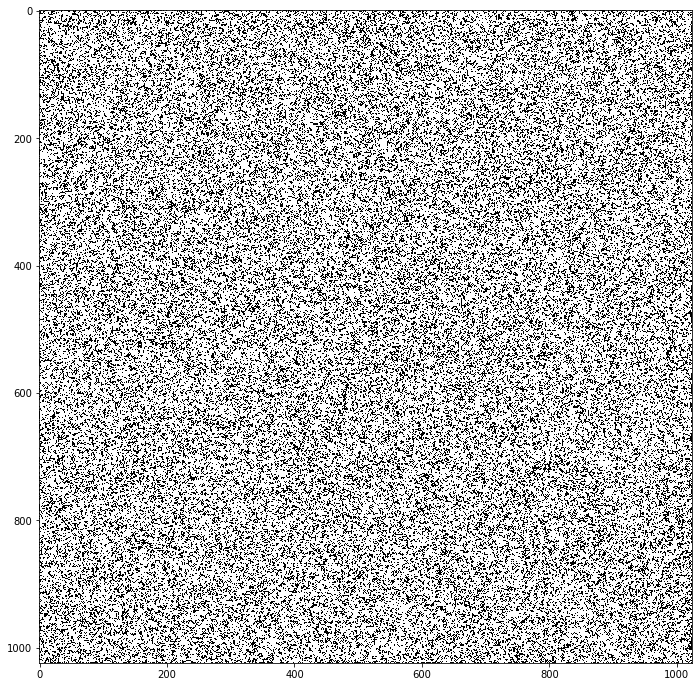

In [6]:
plt.gcf().set_size_inches(12,12)
figure_1 = plt.imshow(tf.squeeze(e[1]),cmap='Greys',origin='upper',interpolation='nearest')

In [0]:
ACCURACY_THRESHOLD = 0.99999

class good_enough(tf.keras.callbacks.Callback): 
 def on_epoch_end(self, epoch, logs={}): 
  if(logs.get('accuracy') > ACCURACY_THRESHOLD): 
    self.model.stop_training = True

earlyStop = tf.keras.callbacks.EarlyStopping(monitor="accuracy")

def get_callbacks():
  return [ good_enough(), earlyStop]

In [0]:
def get_model():
  model = models.Sequential()
  model.add(layers.Conv2D(1, (3, 3), padding='same',activation='relu', input_shape=FEATURES_SHAPE))
  model.add(layers.Dense(7, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer=tf.keras.optimizers.Adam(0.01,decay=1e-7),
              loss='mse',
              metrics=['accuracy'])
  return model

In [9]:
X_COMMON1 = X_COMMON.batch(2)
for i in range(1,100):
  print(f"Model iteration {i} ####################### ")
  model = get_model()
  history = model.fit(X_COMMON1,epochs=100,callbacks=get_callbacks())
  if history.history.get('accuracy')[-1] > ACCURACY_THRESHOLD:
    break
  clear_output()

Model iteration 32 ####################### 
Epoch 1/100
100/100 [==============================] - 3s 33ms/step - loss: 0.1833 - accuracy: 0.7264
Epoch 2/100
100/100 [==============================] - 3s 32ms/step - loss: 0.0932 - accuracy: 0.8654
Epoch 3/100
100/100 [==============================] - 3s 34ms/step - loss: 0.0508 - accuracy: 0.9092
Epoch 4/100
100/100 [==============================] - 3s 33ms/step - loss: 0.0371 - accuracy: 0.9445
Epoch 5/100
100/100 [==============================] - 3s 34ms/step - loss: 0.0203 - accuracy: 0.9940
Epoch 6/100
100/100 [==============================] - 3s 33ms/step - loss: 0.0075 - accuracy: 1.0000


In [10]:
print(history.history.get('accuracy')[-1])

1.0


In [11]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 1024, 1024, 1)     10        
_________________________________________________________________
dense_62 (Dense)             (None, 1024, 1024, 7)     14        
_________________________________________________________________
dense_63 (Dense)             (None, 1024, 1024, 1)     8         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [12]:
testset = get_dataset()
testset1 = testset.batch(2)
model.evaluate(testset1)

100/100 [==============================] - 2s 24ms/step - loss: 0.0049 - accuracy: 1.0000


[0.004946419037878513, 1.0]

In [13]:
len(model.get_weights())

6

In [14]:
model.get_weights()

[array([[[[0.86883295]],
 
         [[0.868496  ]],
 
         [[0.86857766]]],
 
 
        [[[0.8690318 ]],
 
         [[0.35608086]],
 
         [[0.8687091 ]]],
 
 
        [[[0.8689682 ]],
 
         [[0.868673  ]],
 
         [[0.86816597]]]], dtype=float32),
 array([-1.7350574], dtype=float32),
 array([[ 1.5635313 ,  1.803639  ,  1.89102   ,  2.5470588 ,  2.249347  ,
         -0.05518562, -0.6968788 ]], dtype=float32),
 array([-1.2554541 , -1.4511217 , -1.5936311 , -0.00517297, -1.8838631 ,
         0.        ,  0.        ], dtype=float32),
 array([[-2.8821723 ],
        [-2.543532  ],
        [-2.9890716 ],
        [ 3.9521792 ],
        [-2.6522586 ],
        [-0.74433863],
        [-0.7015272 ]], dtype=float32),
 array([-1.4261007], dtype=float32)]

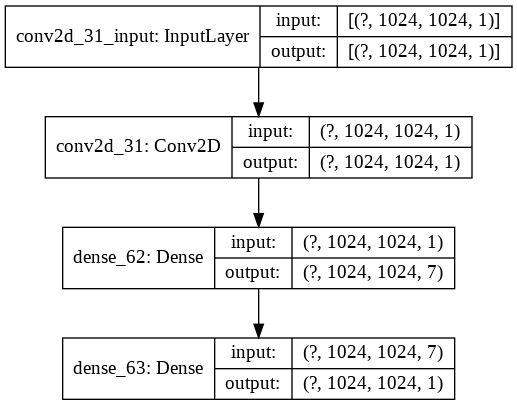

In [15]:
tf.keras.utils.plot_model(model,show_shapes=True)